# I will use the following notebook to demonstrate different steps in preprocessing

## These steps will include:

### 1) Slice timing correction
### 2) Motion correction
### 3) Coregistration
### 4) Spatial and temporal filtering

In [30]:
import os
from glob import glob

# Import new things that we'll need
import pandas as pd
import numpy as np
import nipype.interfaces.afni as afni
import nipype.interfaces.fsl as fsl
from nipype.interfaces.utility import Function
import seaborn as sns
import nibabel as nb
import json
import nipype.interfaces.io as nio
import nipype.pipeline.engine as pe 
import matplotlib.pyplot as plt

%matplotlib inline

### I next want to get a list of all of my functional files

In [31]:
sid = ['021']
base_dir = '/Users/hlee/Documents/GitHub/mattfeld_2020'
work_dir = '/Users/hlee/Documents/GitHub'
func_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/ses-S1/func')
# Get a list of my *localizer* json and nifti converted files
loc_func_json = sorted(glob(func_dir + '/*loc*.json'))
loc_func_files = sorted(glob(func_dir + '/*loc*.nii.gz'))

# Get a list of my *study task* json and nifti converted files
study_func_json = sorted(glob(func_dir + '/*study*.json'))
study_func_files = sorted(glob(func_dir + '/*study*.nii.gz')) #making a list like study_run_1, study_run_2, study_run_3..

### 1) Next I want to build and run function to perform slice timing correction. I'm going to have to extract some important information from the .json files like the multiband slicetiming.

In [36]:
# Here I am building a function that eliminates the
# mapnode directory structure and assists in saving
# all of the outputs into a single directory
def get_subs(func_files):
    '''Produces Name Substitutions for Each Contrast'''
    subs = []
    for curr_run in range(len(func_files)):
        subs.append(('_tshifter%d' %curr_run, ''))
        subs.append(('_volreg%d' %curr_run, ''))
    return subs

# Here I am building a function that takes in a
# text file that includes the number of outliers
# at each volume and then finds which volume (e.g., index)
# has the minimum number of outliers (e.g., min) 
# searching over the first 201 volumes
# If the index function returns a list because there were
# multiple volumes with the same outlier count, pick the first one
def best_vol(outlier_count):
    best_vol_num = outlier_count.index(min(outlier_count[:200]))
    if isinstance(best_vol_num, list):
        best_vol_num = best_vol_num[0]
    return best_vol_num

#####how about min(outlier_count[:more than 200]))???#####
#def best_vol(outlier_count):
    #best_vol_num = outlier_count.index(min(outlier_count[:400]))
    #if isinstance(best_vol_num, list):
        #best_vol_num = best_vol_num[0]
    #return best_vol_num
#####no difference btw 200 and 400 without other changes#####


# Here I am creating a list of lists containing the slice timing for each study run
slice_timing_list = []
for curr_json in study_func_json:
    curr_json_data = open(curr_json)
    curr_study_func_metadata = json.load(curr_json_data)
    slice_timing_list.append(curr_study_func_metadata['SliceTiming'])

# Here I am establishing a nipype work flow that I will eventually execute
psb6351_wf = pe.Workflow(name='psb6351_wf')

# Create a Function node to substitute names of files created during pipeline
getsubs = pe.Node(Function(input_names=['func_files'],
                           output_names=['subs'],
                           function=get_subs),
                  name='getsubs')
getsubs.inputs.func_files = study_func_files

# Here I am inputing just the first run functional data
# I want to use afni's 3dToutcount to find the number of outliers at each volume.  
# I will use this information to later select the earliest volume 
# with the least number of outliers
# to serve as the base for the motion correction
id_outliers = pe.Node(afni.OutlierCount(),
                      name = 'id_outliers')
# Mandatory Inputs
id_outliers.inputs.in_file = study_func_files[0] # Input dataset #if the number is larger, it might reflect various body motions..The first study run is the closest to structure scan

# Optional Inputs
id_outliers.inputs.automask = True # Clip off small voxels
id_outliers.inputs.fraction = True # Write out the fraction of masked voxels which are outliers at each timepoint
id_outliers.inputs.legendre = True # Use Legendre polynomials
id_outliers.inputs.polort = 4 # Detrend each voxel timeseries with polynomials of order 'integer' prior to outlier estimation # 4 is recommended
id_outliers.inputs.out_file = 'outlier_file'


#ATM ONLY: Add an unwarping mapnode here using the field maps


# Create a Function node to identify the best volume based
# on the number of outliers at each volume. I'm searching
# for the index in the first 201 volumes that has the 
# minimum number of outliers and will use the min() function
# I will use the index function to get the best vol. 
getbestvol = pe.Node(Function(input_names=['outlier_count'],
                              output_names=['best_vol_num'],
                              function=best_vol),
                     name='getbestvol')
psb6351_wf.connect(id_outliers, 'out_file', getbestvol, 'outlier_count')

# Extract the earliest volume with the
# the fewest outliers of the first run as the reference 
extractref = pe.Node(fsl.ExtractROI(t_size=1),
                     name = "extractref")
extractref.inputs.in_file = study_func_files[0]
extractref.inputs.t_min = int(np.ceil(nb.load(study_func_files[0]).shape[3]/2)) #PICKING MIDDLE VOLUME of RUN 1
psb6351_wf.connect(getbestvol, 'best_vol_num', extractref, 't_min')

## QUESTION: Would I want to do slice timing correction here?  Why? Why not?
## No, if slice timing correction is performed first, 
## then there is a potential for motion-related intensity differences
## to be propagated across time
## However, it would be okay if data are acquired using a relatively short TR (<= 2sec)

##### I have a question..do I need to do despike in preprocessing? #####

# Below is the command that runs AFNI's 3dTshift command
# this is the node that performs the *slice timing correction*
# I input the study func files as a list and the slice timing 
# as a list of lists. I'm using a MapNode to iterate over the two.
# this should allow me to parallelize this on the HPC
tshifter = pe.MapNode(afni.TShift(),
                      iterfield=['in_file','slice_timing'],
                      name = 'tshifter')
# Mandatory Input
tshifter.inputs.in_file = study_func_files # Input file to 3dT-shift

# Optional Inputs
tshifter.inputs.tr = str(curr_study_func_metadata['RepetitionTime']) # Manually set the TR
tshifter.inputs.slice_timing = slice_timing_list # Time offests from the volume acquisition onset for each slice
tshifter.inputs.outputtype = 'NIFTI_GZ' # AFNI output filetype
tshifter.inputs.tzero = 0.0 # Align each slice to time offset of given slice
tshifter.inputs.interp = 'quintic'# Different interpolation methods # default = Fourier # quintic -> 5th order of polynomial

# Below is the command that runs AFNI's 3dvolreg command.
# this is the node that performs the *motion correction*
# I'm iterating over the functional files which I am passing
# functional data from the slice timing correction node before
# I'm using the earliest volume with the least number of outliers
# during the first run as the base file to register to.
volreg = pe.MapNode(afni.Volreg(),
                    iterfield=['in_file'],
                    name = 'volreg')
# Optional Input
volreg.inputs.outputtype = 'NIFTI_GZ'# AFNI outputtype
volreg.inputs.zpad = 1 # Zeropad around the adges by 'n' voxels during rotations
volreg.inputs.verbose = True # More detailed description of the process
volreg.inputs.interp = 'cubic' # Spatial interpolation methods # default = haptic # cubic -> A polynomial of degree 3
psb6351_wf.connect(tshifter, 'out_file', volreg, 'in_file')
psb6351_wf.connect(extractref, 'roi_file', volreg, 'basefile')

# Below is the code if I wanted to use the FSL McFlirt command
'''
motion_corr = pe.MapNode(fsl.MCFLIRT(),
                         iterfield=['in_file'],
                         name = 'motion_corr')
motion_corr.inputs.output_type = 'NIFTI_GZ'
psb6351_wf.connect(tshifter, 'out_file', motion_corr, 'in_file')
psb6351_wf.connect(extractref, 'roi_file', motion_corr, 'ref_file')
'''

# Below is the node that collects all the data and saves
# the outputs that I am interested in. Here in this node
# I use the substitutions input combined with the earlier
# function to get rid of nesting
datasink = pe.Node(nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join(base_dir, 'derivatives')
datasink.inputs.container = f'sub-{sid[0]}'
psb6351_wf.connect(tshifter, 'out_file', datasink, 'sltime_corr')
psb6351_wf.connect(extractref, 'roi_file', datasink, 'study_ref')
psb6351_wf.connect(volreg, 'out_file', datasink, 'motion.@corrfile')
psb6351_wf.connect(volreg, 'oned_matrix_save', datasink, 'motion.@matrix')
psb6351_wf.connect(volreg, 'oned_file', datasink, 'motion.@par')
psb6351_wf.connect(getsubs, 'subs', datasink, 'substitutions')

# The following two lines set a work directory outside of my 
# local git repo and runs the workflow
psb6351_wf.base_dir = work_dir + f'/psb6351workdir/sub-{sid[0]}'
psb6351_wf.run()


201002-21:00:09,696 nipype.workflow INFO:
	 Workflow psb6351_wf settings: ['check', 'execution', 'logging', 'monitoring']
201002-21:00:09,727 nipype.workflow INFO:
	 Running serially.
201002-21:00:09,728 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.getsubs" in "/Users/hlee/Documents/GitHub/psb6351workdir/sub-021/psb6351_wf/getsubs".
201002-21:00:09,732 nipype.workflow INFO:
	 [Node] Cached "psb6351_wf.getsubs" - collecting precomputed outputs
201002-21:00:09,733 nipype.workflow INFO:
	 [Node] "psb6351_wf.getsubs" found cached.
201002-21:00:09,734 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.tshifter" in "/Users/hlee/Documents/GitHub/psb6351workdir/sub-021/psb6351_wf/tshifter".
201002-21:00:09,742 nipype.workflow INFO:
	 [Node] "psb6351_wf.tshifter" found cached.
201002-21:00:09,743 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.id_outliers" in "/Users/hlee/Documents/GitHub/psb6351workdir/sub-021/psb6351_wf/id_outliers".
201002-21:00:09,746 nipype.workflow INFO:

## 2) Now I will load and plot the motion files

/opt/anaconda3/envs/py376/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


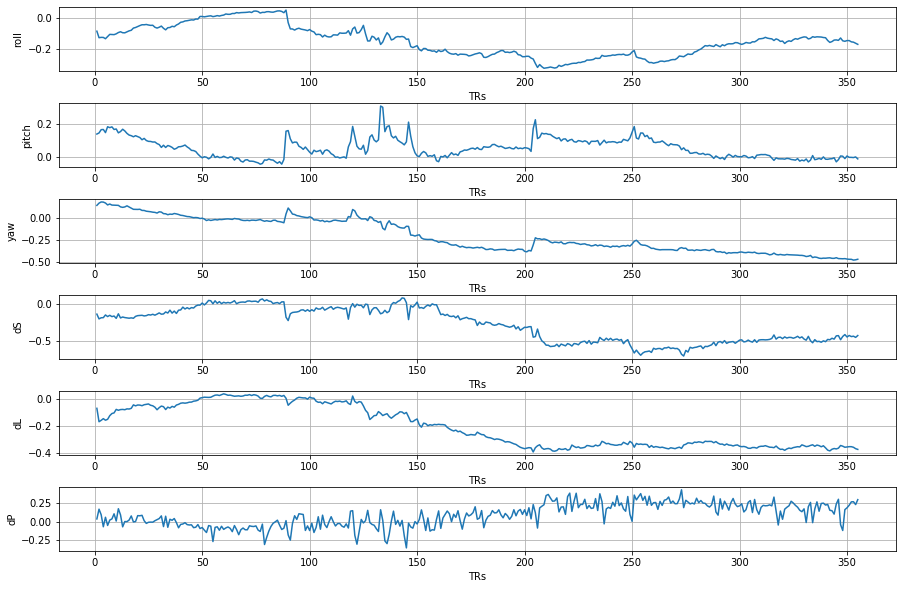

/opt/anaconda3/envs/py376/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


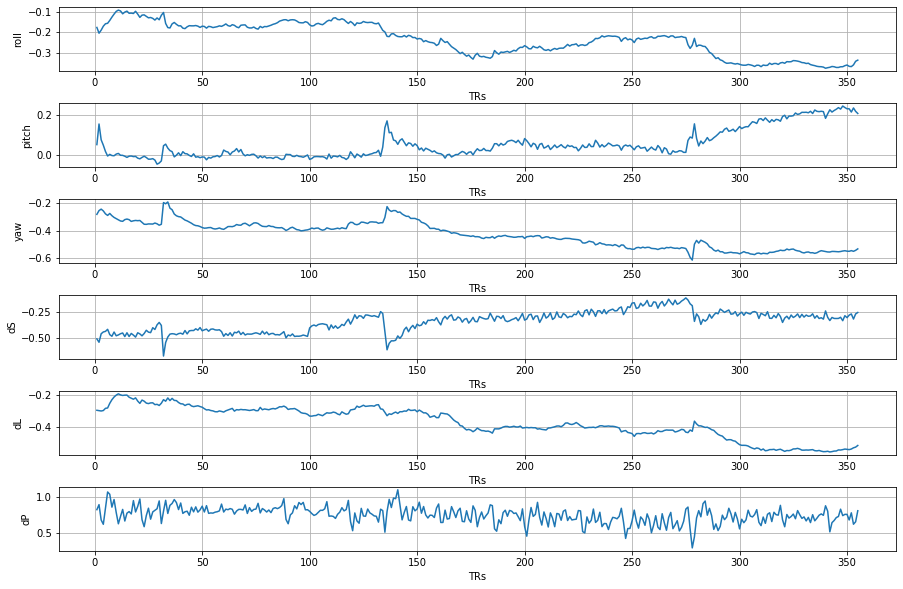

/opt/anaconda3/envs/py376/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


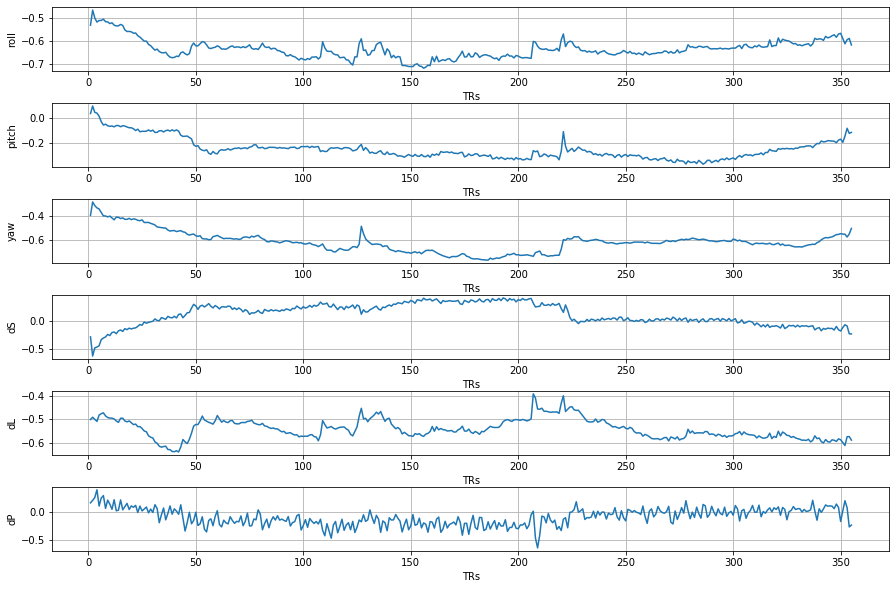

/opt/anaconda3/envs/py376/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


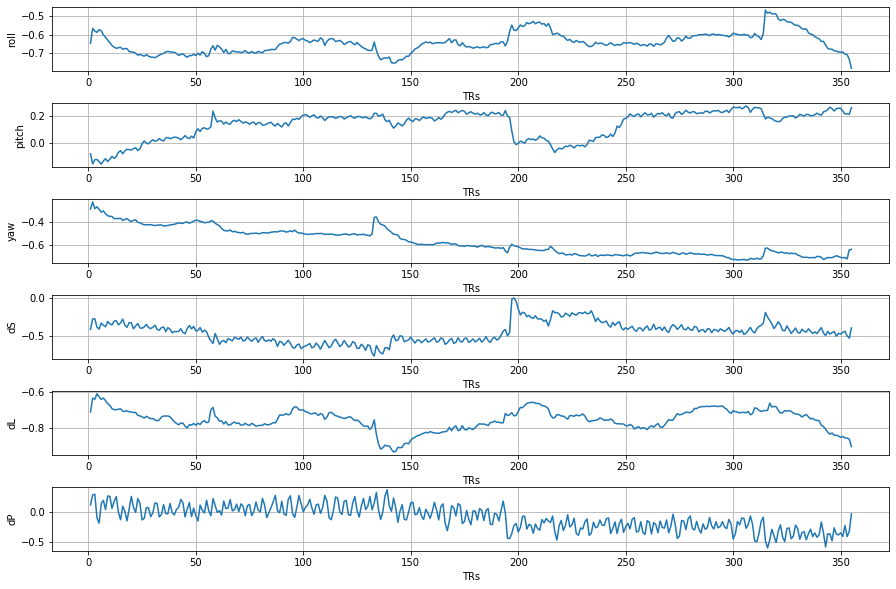

In [37]:
motion_dir = os.path.join(base_dir, f'derivatives/sub-{sid[0]}/motion')
study_motion_files = sorted(glob(motion_dir + '/*study*_tshift.1D'))

for curr_mot_file in study_motion_files:
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']


    num_vols = range(1, len(motion_df)+1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize = (15, 10))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    for idx, curr_col in enumerate(motion_df.keys()):
        axs[idx].plot(num_vols, motion_df[f'{curr_col}'])
        axs[idx].set_xlabel('TRs')
        axs[idx].set_ylabel(f'{curr_col}')
        axs[idx].grid(True)

    plt.show()

In [39]:
study_motcorr_files = sorted(glob(motion_dir + '/*.nii.gz'))
study_motcorr_img_data = nb.load(study_motcorr_files[0]).get_fdata()
study_orig_img_data = nb.load(study_func_files[0]).get_fdata()

#test_motcorr_img_data.shape

print(test_motcorr_img_data[50,50,32,50])
print(study_orig_img_data[50,50,32,50])

NameError: name 'test_motcorr_img_data' is not defined